# __Amazon - Recommendation System__

Dataset From: http://deepyeti.ucsd.edu/jianmo/amazon/index.html

## __Agenda:__

1. Data Processing & EDA
2. Recommendation System Model: Popularity Based
3. Recommendation System Model: Collaborative Filtering (Memory Based - Item Based)
4. Recommendation System Model: Collaborative Filtering (Model Based)

## __1. Data Processing & EDA__

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [2]:
# Load the all beauty main dataset

all_beauty_data = pd.read_json('All_Beauty.json', lines=True)
all_beauty_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


In [3]:
# Load the meta data dataset

all_beauty_meta_data = pd.read_json('meta_All_Beauty.json', lines=True)
all_beauty_meta_data.head(1)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]


We can see that the important columns, "asin" (product ids), "reviewerID" (user id) and "overall" (rating of the product) are available for all rows.

In [4]:
# Quick summary of the dataset

all_beauty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         371345 non-null  int64 
 1   verified        371345 non-null  bool  
 2   reviewTime      371345 non-null  object
 3   reviewerID      371345 non-null  object
 4   asin            371345 non-null  object
 5   reviewerName    371307 non-null  object
 6   reviewText      370946 non-null  object
 7   summary         371139 non-null  object
 8   unixReviewTime  371345 non-null  int64 
 9   vote            51899 non-null   object
 10  style           125958 non-null  object
 11  image           8391 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 31.5+ MB


From the histogram, we can see that the distribution of user ratings are negatively skewed, with a median of 5.0.

In [5]:
all_beauty_data['overall'].describe()

count    371345.000000
mean          4.112093
std           1.362099
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

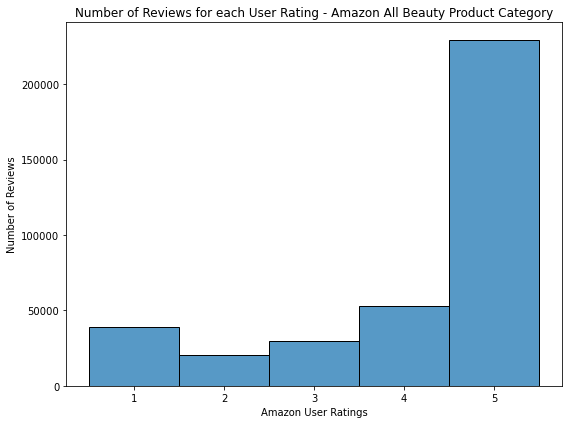

In [6]:
# Understand the distribution of user ratings

plt.figure(figsize=[8,6])

sns.histplot(x='overall', discrete=True, data=all_beauty_data)
plt.xlabel('Amazon User Ratings')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for each User Rating - Amazon All Beauty Product Category')

plt.tight_layout()
plt.show()

For Amazon's All Beauty dataset, we can see that:
- Total Number of Ratings: 371,345.
- Total Number of Unique Users: 324,038.
- Total Number of Unique Products: 32,586.

In [7]:
# Find out number of uniques users and products

print(f"Total Ratings: {all_beauty_data['overall'].count()}\nTotal Unique Users: {len(np.unique(all_beauty_data['reviewerID']))}\nTotal Unique Products: {len(np.unique(all_beauty_data['asin']))}")

Total Ratings: 371345
Total Unique Users: 324038
Total Unique Products: 32586


Additionally, we can see that:
- Median number of reviews per user is 1.
- Median number of reviews per product is 2.

In [8]:
# Understand how many reviews each user performed

no_reviews_user = all_beauty_data.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_reviews_user.head(10)

reviewerID
A2GJX2KCUSR0EI    27
A1KSC91G9AIY2Z    23
A22CW0ZHY3NJH8    21
A1EGCED01USBA9    21
AENH50GW3OKDA     20
A1UQBFCERIP7VJ    18
A11WQTPV352LGH    14
A1XQ0F01CF84Y3    14
A3NFZN1GS1RKR9    13
A1VUXNNB1NJ2PT    13
Name: overall, dtype: int64

In [9]:
no_reviews_user.describe()

count    324038.000000
mean          1.145992
std           0.506462
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          27.000000
Name: overall, dtype: float64

In [10]:
# Understand how many reviews each product received

no_reviews_product = all_beauty_data.groupby(by='asin')['overall'].count().sort_values(ascending=False)
no_reviews_product.head(10)

asin
B000FOI48G    8672
B000GLRREU    8341
1620213982    4792
B001QY8QXM    4544
B01DKQAXC0    4246
B00W259T7G    2959
B006IB5T4W    2790
B00005JS5C    2249
B0012Y0ZG2    2234
B000WYJTZG    2190
Name: overall, dtype: int64

In [11]:
no_reviews_product.describe()

count    32586.000000
mean        11.395845
std         97.384461
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       8672.000000
Name: overall, dtype: float64

## __2. Recommendation System Model: Popularity Based__

As the name suggests, popularity based recommendation system works based on what's trending.

The challenge with this method is that it doesn't take into account personalizaton or the user's preferences.

In [12]:
top_beauty_products = all_beauty_data.groupby('asin').filter(lambda x: x['overall'].count() >= 50)
top_beauty_products.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
23,5,False,"05 16, 2012",A1DN3KBTCYBH6K,1620213982,Amazon Customer,The product was cute and easy to use. It arri...,cute!,1337126400,NaN,{'Size:': ' 44 oz'},NaN
24,5,True,"02 26, 2012",A1TA38LWZO0NZS,1620213982,deucez24,Fun had by all. Game night just got better. ...,"Fun twist to the old favorite, Bingo.",1330214400,NaN,{'Size:': ' 300'},NaN
25,5,True,"01 16, 2012",A2OZBC5SG575G1,1620213982,Jean A.,You will love this card. I'm going to use for...,ADORABLE Cards!,1326672000,NaN,{'Size:': ' 3 pack'},NaN
26,5,True,"11 24, 2011",A2YKYIA11M9XTX,1620213982,Booklady,Robert Sabuda's cards are always magical and t...,Send a smile to someone you love!,1322092800,5,{'Size:': ' 3 pack'},NaN
27,5,True,"10 29, 2011",A32MUH70JIV7TS,1620213982,sallyftw,I thought the previous reviewers were exaggera...,HUUUUGE!,1319846400,NaN,{'Size:': ' 3'},NaN


In [13]:
# Similar to what we saw earlier, this is the list of products that have at least 50 review ratings

top_no_reviews_product =  top_beauty_products.groupby('asin')['overall'].count().sort_values(ascending=False)
top_no_reviews_product

asin
B000FOI48G    8672
B000GLRREU    8341
1620213982    4792
B001QY8QXM    4544
B01DKQAXC0    4246
              ... 
B01BYNTXXQ      50
B000Q4AIHU      50
B000NPVD7Q      50
B01DKI8S1Q      50
B00028ORTK      50
Name: overall, Length: 1149, dtype: int64

We can clearly see there's a smaller proportion of products that receive a ton of reviews followed by a long tail of products. In other words, this "short head" of products are the truly popular ones.

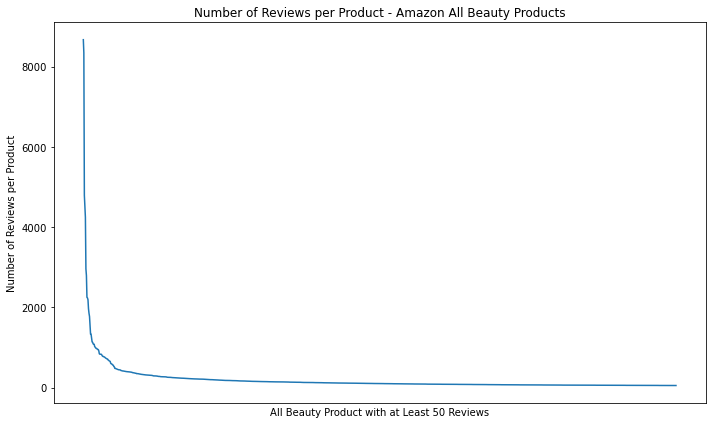

In [14]:
plt.figure(figsize=[10,6])

sns.lineplot(x=top_no_reviews_product.index, y=top_no_reviews_product.values)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
) # Used to remove xticks and xtick labels
plt.xlabel('All Beauty Product with at Least 50 Reviews')
plt.ylabel('Number of Reviews per Product')
plt.title('Number of Reviews per Product - Amazon All Beauty Products')

plt.tight_layout()
plt.show()

In [15]:
top_beauty_products_review_count_score = top_beauty_products.groupby('asin')['overall'] \
    .agg(('count','mean')) \
    .rename(columns={'count': 'review_count', 'mean': 'mean_review_score'}) \
    .sort_values(by='review_count', ascending=False)

top_beauty_products_review_count_score.head()

,review_count,mean_review_score
asin,,
B000FOI48G,8672,4.393450
B000GLRREU,8341,4.405107
1620213982,4792,4.798414
B001QY8QXM,4544,4.556118
B01DKQAXC0,4246,4.209138


<Figure size 864x720 with 0 Axes>

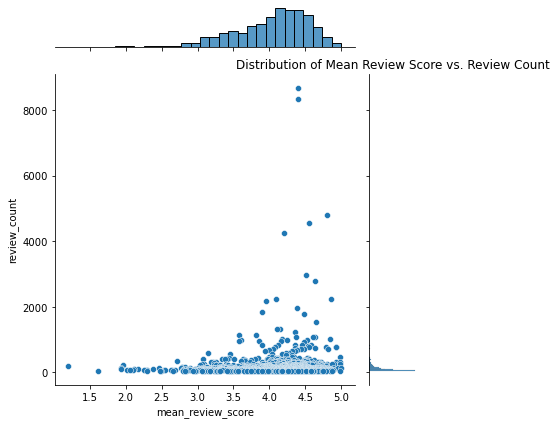

In [16]:
plt.figure(figsize=[12,10])

sns.jointplot(x='mean_review_score', y='review_count', data=top_beauty_products_review_count_score)
plt.xlabel('Number of Reviews')
plt.ylabel('Mean Review Score')
plt.title('Distribution of Mean Review Score vs. Review Count')

plt.tight_layout()
plt.show()

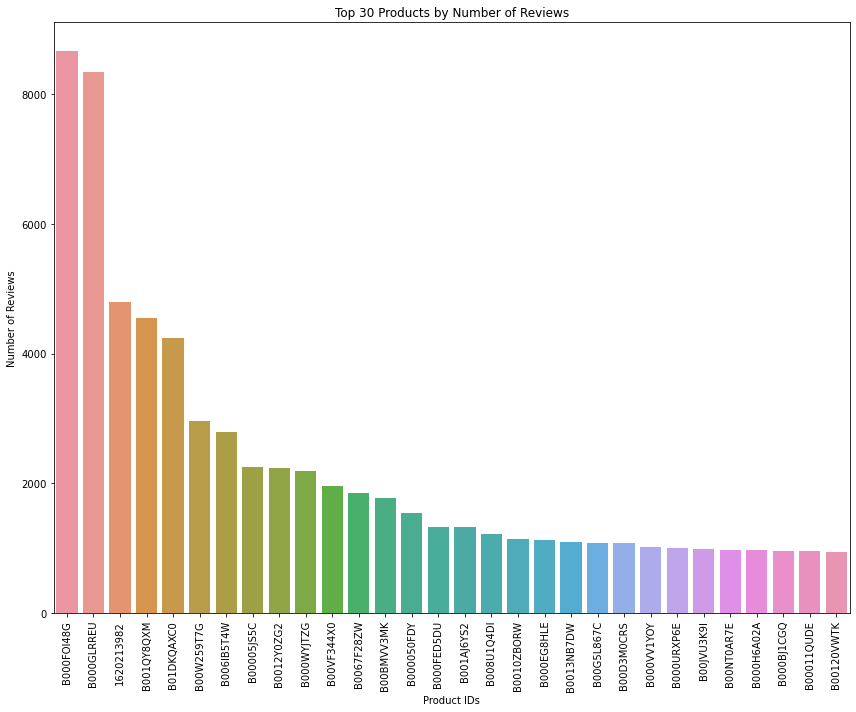

In [17]:
plt.figure(figsize=[12,10])

sns.barplot(x=top_beauty_products_review_count_score.index[:30], y='review_count', data=top_beauty_products_review_count_score[:30])
plt.xticks(rotation=90)
plt.xlabel('Product IDs')
plt.ylabel('Number of Reviews')
plt.title('Top 30 Products by Number of Reviews')

plt.tight_layout()
plt.show()

In [18]:
print(f"With Popularity Based Recommendation System, the top {len(top_beauty_products_review_count_score.index[:30])} products to recommend are:")
for index, asin in enumerate(list(top_beauty_products_review_count_score.index[:30])):
    print(f"Item {index+1}: {asin} - {all_beauty_meta_data[all_beauty_meta_data['asin'] == asin]['title'].values}.")

With Popularity Based Recommendation System, the top 30 products to recommend are:
Item 1: B000FOI48G - ['Waterpik Ultra Water Flosser'].
Item 2: B000GLRREU - ['Waterpik Ultra Water Flosser'].
Item 3: 1620213982 - [].
Item 4: B001QY8QXM - ['Astra Platinum Double Edge Safety Razor Blades ,100 Blades (20 x 5)'].
Item 5: B01DKQAXC0 - ['Bali Secrets Natural Deodorant - Organic &amp; Vegan - For Women &amp; Men - All Day Fresh - Strong &amp; Reliable Protection - 2.5 fl.oz/75ml [Scent: Sandalwood]'].
Item 6: B00W259T7G - ['Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp; Rich Lather (150 grams) - Raspberry'].
Item 7: B006IB5T4W - ['Aquaphor Healing Ointment,Advanced Therapy Skin Protectant 14 Ounce ( Pack May Vary )'].
Item 8: B00005JS5C - ['Panasonic Bikini Shaper and Trimmer for Women ES246AC; Compact; Portable Design with Adjustable Trim Settings; Battery Operated'
 'Panasonic Bikini Shaper and Trimmer for Women ES246AC; Compact; Portabl

And here we are, these are the top 30 products that can be utilized in our Popularity Based Recommendation System.

## __3. Recommendation System Model: Collaborative Filtering (Memory Based - Item Based)__

Collaborative filtering mimics user-to-user recommendations. So it recommends products based on users who have similar tastes (derived from historical item ratings of like-minded people to predict how someone would rate an item).

__By filling in entries of a user-item association matrix.__

Collaborative filtering has two sub-categories: memory-based or model-based approaches.

In [19]:
# Import libraries

# !pip install surprise # https://surprise.readthedocs.io/en/stable/
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

ModuleNotFoundError: No module named 'surprise'

In [ ]:
# Instantiate Reader and pass in top beauty products with at least 50 reviews

reader = Reader(rating_scale=(1,5)) # Reader class used to parse file containing ratings

# Now, we load a dataset from a pandas dataframe
# It must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings, in this order
recommender_cf_data = Dataset.load_from_df(top_beauty_products[['reviewerID','asin','overall']], reader) 

In [ ]:
# Quick look at the dataframe we are passing to the Dataset.load_from_df()

top_beauty_products[['reviewerID','asin','overall']]

In [ ]:
# Split dataset

train_set, test_set = train_test_split(data=recommender_cf_data, test_size=0.3, random_state=100)

Quick explanation of the recommendation system algorithm used below - KNNWithMeans:

- Takes into account mean ratings of each user.
- sim_options 'name': The similarity measure we intend to use (e.g. Cosine Similarity, Shrunk Pearson Correlation Coefficient).
- https://surprise.readthedocs.io/en/stable/similarities.html#module-surprise.similarities
- sim_options 'user_based': Whether similarities will be computed between users or between items. This has a huge impact on the performance of a prediction algorithm. __True = Between users; False = Between items.__
- https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration
- In our case, we use the __item-item approach__ simply because user-user collaborative filtering required huge computational power. So this is more efficient.

In [ ]:
# Item-item collaborative filtering

knn_means_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False}) # Instantiate the model
knn_means_model.fit(train_set) # Fit model to training set

In [ ]:
# Predict with the model against test set

knn_means_model_preds = knn_means_model.test(test_set)

In [ ]:
knn_means_model_preds[:5]

RMSE - Root Mean Square Error: The standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are. RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

How to interpret RMSE?
- Whether RMSE is "small" or "big" depends on the choice of units and on the application we are building for.
- In our case, a RMSE of 1.25 means there's a standard deviation of 1.25 in review ratings.
- Whether it's good or bad requires our domain knowledge to gauge - from our data set, based on the distribution of review ratings for products with at least 50 reviews, it has a standard deviation of 1.31.

In [ ]:
# If we take a look at the distribution of review ratings for products with at least 50 reviews, it has a standard deviation of 1.31.

top_beauty_products['overall'].describe()

In [ ]:
# Accuracy score with RMSE

print(f"Item-Item Collaborative Filtering Model Accuracy (RMSE) on Test Set: {accuracy.rmse(knn_means_model_preds, verbose=True)}")

When we predict with the model, it will tell us for the "uid" (user id), what is the "est" (estimated rating) they will give to the "iid" (product id).

- https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict

In [ ]:
# Prediction example

knn_means_model.predict(uid='A2GJX2KCUSR0EI', iid='B000GLRREU')

In [ ]:
print(f"For Memory Based, Item Based Collaborative Filtering: The user {knn_means_model.predict(uid='A2GJX2KCUSR0EI', iid='B000GLRREU').uid} will give a rating of {knn_means_model.predict(uid='A2GJX2KCUSR0EI', iid='B000GLRREU').est} for Product ID {knn_means_model.predict(uid='A2GJX2KCUSR0EI', iid='B000GLRREU').iid}.")

## __4. Recommendation System Model: Collaborative Filtering (Model Based)__

The model based approach to collaboratie filtering for our recommendation system relies on existing user-item interactions to train the model to predict what items a user might like the most.

__By training models to make predictions.__

Compared to memory based approaches, this has an added advantage of being able to recommend a wider variety of items to a wider group of users.

In [ ]:
# Create a sparse matrix documenting each user's review for every top beauty products with at least 50 reviews

user_product_ratings_matrix = top_beauty_products.pivot_table(values='overall', index='reviewerID', columns='asin', fill_value=0)
user_product_ratings_matrix.head(3)

In [ ]:
# Transpose the matrix

user_product_ratings_matrix_transposed = user_product_ratings_matrix.T
user_product_ratings_matrix_transposed.head(3)

In [ ]:
# Import library

from sklearn.decomposition import TruncatedSVD

In [ ]:
# Decompose the matrix

svd_model = TruncatedSVD(n_components=200)
decomposed_matrix = svd_model.fit_transform(user_product_ratings_matrix_transposed)
decomposed_matrix.shape

In [ ]:
svd_model.explained_variance_ratio_.sum()

In this section, we will take an "asin" (product id) and identify what other products can be recommended if a user bought this product. (E.g. B00120VWTK)

In [ ]:
# Correlation matrix - For each product against each product (these are top beauty products with at least 50 reviews)

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

In [ ]:
# Find the index of the product we want to investigate

product_id = 'B00120VWTK'

top_product_ids = list(user_product_ratings_matrix_transposed.index)
product_id_index = top_product_ids.index(product_id)
product_id_index

In [ ]:
# View the correlation of the investigated product against all other products

correlation_product_id = correlation_matrix[product_id_index]
correlation_product_id.shape

Now, based on what the product is strongly correlated against, we can recommend the other products.

- I.e. These are the other products to recommend if a user purchased this product.

In [ ]:
recommendations = list(user_product_ratings_matrix_transposed.index[correlation_product_id > 0.70])
recommendations.remove(product_id) # Remove the product already bought by the user
recommendations # Returns the list of recommended products

In [ ]:
# Write a function to print out the product the user bought as well as what products can be recommended based

def recommdation_details(product_id, recommendations):
    print(f"Since User bought Product ID: {product_id}, {all_beauty_meta_data[all_beauty_meta_data['asin'] == product_id]['title'].values}.\n")
    print('For Model Based Collaborative Filtering, We can recommend these Products:\n')
    for asin in recommendations:
        print(f"Recommended Product ID: {asin}, {all_beauty_meta_data[all_beauty_meta_data['asin'] == asin]['title'].values}. It has a correlation score of {correlation_product_id[user_product_ratings_matrix_transposed.index.get_loc(asin)]:.3f}.")

In [ ]:
# Retrieve the recommendations in a user friendly and readable format

recommdation_details(product_id, recommendations)

### The End.
### Thank You!